In [3]:
OPENAI_API_KEY="***REMOVED***"

In [10]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0,api_key=OPENAI_API_KEY)

# llm.invoke("How to learn system design as a backend developer?").content



# **ToolNode**


## **Imports libraries**


In [37]:
from langgraph.graph import MessagesState,StateGraph,START,END
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import tools_condition
from typing import Annotated, TypedDict
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
from datetime import datetime
from IPython.display import Image, display


## **Memory adding**


In [51]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

## **States**


In [38]:
class MyState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

## **Tools**


In [39]:
@tool
def add(a: int, b: int) -> int:
    """Add two numbers together"""
    return a + b

@tool
def subtract(a: int, b: int) -> int:
    """Subtract two numbers"""
    return a - b


@tool
def multiply(a: int, b: int) -> int:
    """Multiply two numbers"""
    return a * b


@tool
def divide(a: int, b: int) -> float:
    """Divide two numbers"""
    if b == 0:
        return "Error: Division by zero"
    return a / b

@tool
def get_current_time() -> str:
    """Get the current time"""
    return datetime.now().strftime("%Y-%m-%d %H:%M:%S")


@tool
def get_current_date() -> str:
    """Get the current date"""
    return datetime.now().strftime("%Y-%m-%d")


@tool
def get_current_day() -> str:
    """Get the current day of the week"""
    return datetime.now().strftime("%A")

tools = [add, subtract, multiply, divide, get_current_time, get_current_date, get_current_day]
llm_with_tools = llm.bind_tools(tools)


## **Binds tools with LLM**


In [40]:
def tool_calling_llm(state: MyState) -> MyState:
    """Call the LLM to get the result"""
    messages = state["messages"]
    llm_response = llm_with_tools.invoke(messages)
    return {"messages": [llm_response]}

## **Graph Builder**


In [53]:
builder = StateGraph(MyState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition,
)
builder.add_edge("tools", "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
workflow = builder.compile(checkpointer=memory)

## **Graph**


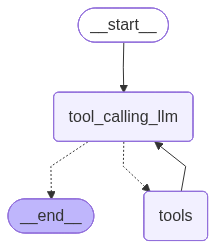

In [54]:
display(Image(workflow.get_graph().draw_mermaid_png()))

In [57]:
user_input = [HumanMessage(content="Now divide the previous result by 2")]
config={"configurable":{"thread_id":"123"}}
message=workflow.invoke({"messages": user_input},config=config)

for msg in message["messages"]:
    msg.pretty_print()

================================ Human Message =================================

Hey buddy, Multiply 2 and 3 and then multiply the result with 4
================================== Ai Message ==================================
Tool Calls:
  multiply (call_sw5WRwslCYr8xYkfC0yrSEJt)
 Call ID: call_sw5WRwslCYr8xYkfC0yrSEJt
  Args:
    a: 2
    b: 3
  multiply (call_JbiOwjeNzdoQJEUCJsORu6lB)
 Call ID: call_JbiOwjeNzdoQJEUCJsORu6lB
  Args:
    a: 6
    b: 4
================================= Tool Message =================================
Name: multiply

6
================================= Tool Message =================================
Name: multiply

24
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6. Then, multiplying that result (6) by 4 gives us 24.
================================ Human Message =================================

Now divide the previous result by 2
================================== Ai Message ======

1. Add Message reducer =>add_messages
2. Remove message =>RemoveMessage


## **Chatbot summarization**


In [144]:
from langchain_core.messages import SystemMessage,RemoveMessage
class ChatbotSummary(MessagesState):
    summary: str

In [145]:
def call_model(state: ChatbotSummary) -> ChatbotSummary:
    summary = state["messages"]
    
    if summary:
        # Add summary to the system message
        system_message = f"Here is the summary of the conversation: {summary}"
        messages = [SystemMessage(content=system_message)]+state["messages"]
    else:
        messages = state["messages"]
    llm_response = llm.invoke(messages)
    return {"messages": llm_response}

In [146]:
def summarize_conversation(state: ChatbotSummary) -> ChatbotSummary:
    summary = state["messages"]
    
    if summary:
        # Add summary to the system message
        system_message = (
            f"Here is the summary of the conversation:\n\n {summary}"
            "Extend the summary to include the latest conversation"
        )
    else:
        system_message = "Create a summary of the conversation above"
        
    messages = state["messages"]+[HumanMessage(content=system_message)]
    llm_response = llm.invoke(messages).content
    
    delete_message = [RemoveMessage(id=msg.id) for msg in state["messages"][:-2]]
    return {"summary":llm_response,"messages":delete_message}

In [147]:
from langgraph.graph import MessagesState,StateGraph,START,END

def should_continue(state: ChatbotSummary) -> str:
    """Determine whether to continue or not"""
    messages = state["messages"]
    
    if len(messages) > 6:
        result = "summarize_conversation"
    else:
        result = "end"
    
    return result

In [148]:
workflow = StateGraph(ChatbotSummary)

workflow.add_node("conversation", call_model)
workflow.add_node("summarize_conversation", summarize_conversation)

workflow.add_edge(START, "conversation")
workflow.add_conditional_edges(
    "conversation",
    should_continue,
    {
        "summarize_conversation": "summarize_conversation",
        "end": END
    }
)

workflow.add_edge("summarize_conversation", END)

memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)

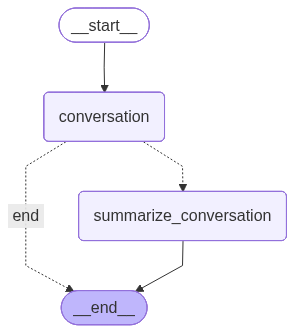

In [149]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [150]:
config={"configurable":{"thread_id":"123345"}}

In [151]:
user_input=[HumanMessage(content="Hii my name is EHtsham")]
message=graph.invoke({"messages": user_input},config=config)

for msg in message["messages"]:
    msg.pretty_print()

user_input=[HumanMessage(content="What is my name?")]
message=graph.invoke({"messages": user_input},config=config)

for msg in message["messages"]:
    msg.pretty_print()

user_input=[HumanMessage(content="I like to play bedminton")]
message=graph.invoke({"messages": user_input},config=config)

for msg in message["messages"]:
    msg.pretty_print()

================================ Human Message =================================

Hii my name is EHtsham
================================== Ai Message ==================================

Hi Ehtsham! Nice to meet you. How can I assist you today?
================================ Human Message =================================

Hii my name is EHtsham
================================== Ai Message ==================================

Hi Ehtsham! Nice to meet you. How can I assist you today?
================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

Your name is Ehtsham.
================================ Human Message =================================

Hii my name is EHtsham
================================== Ai Message ==================================

Hi Ehtsham! Nice to meet you. How can I assist you today?
================================ Human Message ===============

In [152]:
graph.get_state(config).values.get("summary")

In [153]:
user_input=[HumanMessage(content="I like hi Yuqi from China, is he the best player in the world?")]
message=graph.invoke({"messages": user_input},config=config)

for msg in message["messages"]:
    msg.pretty_print()

================================ Human Message =================================

I like hi Yuqi from China, is he the best player in the world?
================================== Ai Message ==================================

Hi Yuqi is a talented badminton player, and he has achieved significant success in his career. However, whether he is considered the "best" player in the world can vary depending on current rankings and opinions. As of my last update, players like Kento Momota and Viktor Axelsen have also been regarded as top players. Rankings can change frequently, so it's always good to check the latest updates!


In [154]:
graph.get_state(config).values.get("summary")

'Sure! Here’s an extended summary of our conversation, including the latest exchanges:\n\n1. **Ehtsham Introduces Himself**: Ehtsham greets and shares his name.\n2. **AI Responds**: The AI responds warmly, asking how it can assist Ehtsham.\n3. **Ehtsham Asks About His Name**: Ehtsham inquires about his name.\n4. **AI Confirms Name**: The AI confirms that his name is Ehtsham.\n5. **Ehtsham Shares His Interest**: Ehtsham mentions that he likes to play badminton.\n6. **AI Responds Positively**: The AI acknowledges that badminton is a fun sport and asks how often Ehtsham plays.\n7. **Ehtsham Mentions Hi Yuqi**: Ehtsham expresses his admiration for Hi Yuqi from China and asks if he is the best player in the world.\n8. **AI Provides Information**: The AI responds that Hi Yuqi is a talented player but notes that the title of "best player" can vary based on rankings and opinions, mentioning other top players like Kento Momota and Viktor Axelsen.\n\nIf there\'s anything else you\'d like to add 

# **SQLlite memory**


In [155]:
import sqlite3

connection = sqlite3.connect(":memory:")

In [156]:
db_path = "memory.db"
connection = sqlite3.connect(db_path,check_same_thread=False)

In [157]:
from langgraph.checkpoint.sqlite import SqliteSaver

checkpointer = SqliteSaver(connection)


In [158]:
workflow = StateGraph(ChatbotSummary)

workflow.add_node("conversation", call_model)
workflow.add_node("summarize_conversation", summarize_conversation)

workflow.add_edge(START, "conversation")
workflow.add_conditional_edges(
    "conversation",
    should_continue,
    {
        "summarize_conversation": "summarize_conversation",
        "end": END
    }
)

workflow.add_edge("summarize_conversation", END)

memory = MemorySaver()
graph = workflow.compile(checkpointer=checkpointer)

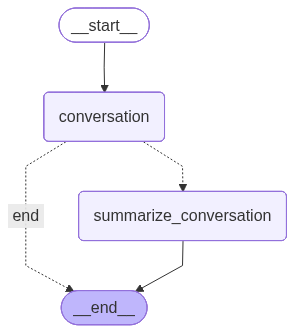

In [159]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [160]:
config={"configurable":{"thread_id":"sqlite_memory"}}

In [161]:
user_input=[HumanMessage(content="Hii my name is EHtsham")]
message=graph.invoke({"messages": user_input},config=config)

for msg in message["messages"]:
    msg.pretty_print()

user_input=[HumanMessage(content="What is my name?")]
message=graph.invoke({"messages": user_input},config=config)

for msg in message["messages"]:
    msg.pretty_print()

user_input=[HumanMessage(content="I like to play bedminton")]
message=graph.invoke({"messages": user_input},config=config)

for msg in message["messages"]:
    msg.pretty_print()

================================ Human Message =================================

Hii my name is EHtsham
================================== Ai Message ==================================

Hi Ehtsham! Welcome back! How can I assist you today?
================================ Human Message =================================

Hii my name is EHtsham
================================== Ai Message ==================================

Hi Ehtsham! Welcome back! How can I assist you today?
================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

Your name is Ehtsham.
================================ Human Message =================================

Hii my name is EHtsham
================================== Ai Message ==================================

Hi Ehtsham! Welcome back! How can I assist you today?
================================ Human Message ===========================

In [162]:
graph.get_state(config).values.get("summary")

'Sure! Here’s an extended summary of the conversation, including the latest exchanges:\n\n1. **User Introduction**: Ehtsham introduces himself.\n   - **User**: "Hii my name is EHtsham"\n   - **AI**: "Hi Ehtsham! Nice to meet you. How can I assist you today?"\n\n2. **Name Confirmation**: Ehtsham asks for confirmation of his name.\n   - **User**: "What is my name?"\n   - **AI**: "Your name is Ehtsham."\n\n3. **Interest in Badminton**: Ehtsham shares his interest in badminton.\n   - **User**: "I like to play bedminton."\n   - **AI**: "That\'s great! Badminton is a fun and fast-paced sport. How often do you play?"\n\n4. **Reintroduction**: Ehtsham reintroduces himself.\n   - **User**: "Hii my name is EHtsham."\n   - **AI**: "Hi Ehtsham! Welcome back! How can I assist you today?"\n\nIf there\'s anything specific you\'d like to add or discuss further, let me know!'

# **Streaming Response**


In [166]:
config_stream={"configurable":{"thread_id":"streaming_response"}}
user_input=[HumanMessage(content="Hii my name is EHtsham")]

for chunks in graph.stream({"messages": user_input},config_stream,stream_mode="update"):
    print(chunks)
